Get best bin sizes from comparing to Travis ages, also adding columns in the end for errors

In [189]:
from HeaderP import *
import Astraea
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
import random
import time
from tqdm import trange

In [190]:
df_prot=pd.read_pickle('minchisq.pkl')
#df_rvar=pd.read_pickle('minchisq_rvar.pkl')

df_rvar=pd.read_pickle('newProtfromRvar.pkl')
df_isoages=pd.read_table('GKSPCPapTable2.txt',delimiter='&')
df_rvar=pd.merge(df_isoages,df_rvar,left_on='KIC',right_on='KID',how='inner')
df_rvar=df_rvar.dropna(subset=['iso_age'])


In [191]:
print(len(df_rvar))
#df_rvar=df_rvar.loc[~df_rvar['KID'].isin(df_prot.KID)]
print(len(df_rvar))

77292
77292


In [192]:
mpf = 'aviary/data/metal_poor_avr.csv'
mrf = 'aviary/data/metal_rich_avr.csv'
af = 'aviary/data/all_stars_avr.csv'
def get_avr_coefficients():
    """
    Fit the parameters of the AVR using data from Yu & Liu:
    https://arxiv.org/pdf/1712.03965.pdf
    Fit to the relationship between log(sigma_z) and age.
    Returns:
        p_mp (array): coefficients [slope, intercept] for straight line fit to
            metal poor stars.
        p_mr (array): coefficients [slope, intercept] for straight line fit to
            metal rich stars.
        p_a (array): coefficients [slope, intercept] for straight line fit to
            all stars.
    """
    mp = pd.read_csv(mpf)
    mr = pd.read_csv(mrf)
    a = pd.read_csv(af)

    p_mp = np.polyfit(np.log(mp.sigma_z_kms), np.log(mp.Age_Gyr), 1)
    p_mr = np.polyfit(np.log(mr.sigma_z_kms), np.log(mr.Age_Gyr), 1)
    p_a = np.polyfit(np.log(a.sigma_z_kms), np.log(a.Age_Gyr), 1)

    return p_mp, p_mr, p_a

def v_to_age(v, coeffs):
    """
    Convert z velocity dispersion [km/s] to age [Gyr]
    Args:
        v (array): Z Velocity dispersion [km/s].
        coeffs (array): coefficients for straight line fit. [intercept, slope]
    Returns:
        age (array): age in Gyr.
    """
    b, a = coeffs
    logt = np.polyval(coeffs, np.log(v))
    return np.exp(logt)

def genErr(dv, dv_err):
    errorRand=np.random.normal(0, 1, len(dv))
    return dv+dv_err*errorRand


# get average ages
def getAveAges(df,fs,binfs):
    
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    iso_age=df['iso_age'].values
    iso_age_err=df['iso_age_err1'].values
    
    iso_ave=np.zeros(len(df))
    iso_ave_err=np.zeros(len(df))
    
    vels=df['v_b'].values
    kin_age=np.zeros(len(df))
    
    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        
        iso_age_single=iso_age[mask]
        iso_age_err_single=iso_age_err[mask]
        
        weights=1/np.power(iso_age_err_single,2)
        iso_ave[i]=sum((iso_age_single*weights)/sum(weights))
        iso_ave_err[i]=np.sqrt(sum(iso_age_err_single)**2)
        
        vels_single=vels[mask]
        
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
        
        
    p_mp, p_mr, p_a = get_avr_coefficients()
    #df['vel_dis']=kin_age
    #df['iso_age_ave']=iso_ave
    #df['iso_age_ave_err']=iso_ave_err
    return v_to_age(kin_age,p_mr),iso_ave,iso_ave_err

import time
from tqdm import trange
# get average ages
def getkinAges(df,fs,binfs):
    df=df.reset_index(drop=True)
    fslen=len(fs)
    dflen=len(df)
    
    checkpara=np.zeros(fslen)
    paras=np.zeros((dflen,fslen))
    for i in range(fslen):
        paras[:,i]=df[fs[i]].values
    
    vels=df['v_b'].values
    kin_age=np.zeros(len(df))
    
    for i in trange(dflen):
        
        mask=np.ones(dflen, dtype=bool)
        
        for j in range(fslen):
            checkpara[j]=paras[i,j]
            mask = mask & (abs(paras[:,j]-checkpara[j])<binfs[j]/2)
        vels_single=vels[mask]
        kin_age[i]=1.5*np.median(abs(vels_single-np.median(vels_single)))
        
        
    p_mp, p_mr, p_a = get_avr_coefficients()
    #df['vel_dis']=kin_age
    #df['kin_age']=v_to_age(kin_age,p_mr)
    return kin_age,v_to_age(kin_age,p_mr)
    #print(v_to_age(kin_age,p_mr))
    
import time
from tqdm import trange
# get average ages
def getkinAges_err(df,fs,binfs,sampsize=10):
    df=df.dropna(subset=['v_b'])
    bin_low=[i*0.5 for i in binfs]
    bin_hi=[i*1.5 for i in binfs]
    
    bins=np.zeros((len(binfs),sampsize))
    ages=np.zeros((len(df),sampsize))
    for i in range(len(binfs)):
        bins[i,:]=np.linspace(bin_low[i],bin_hi[i],sampsize)
    for i in range(sampsize):
        getkinAges(df,fs,bins[:,i])
        ages[:,i]=df['kin_age']
    getkinAges(df,fs,binfs)
    
    df['kin_age_err']=[np.std(pd.Series(ages[i,:]).dropna()) for i in range(len(df))] 
    return ages


    

In [195]:
df_rvar=df_rvar.loc[df_rvar['logg']>4]
print(len(df_rvar))

77292


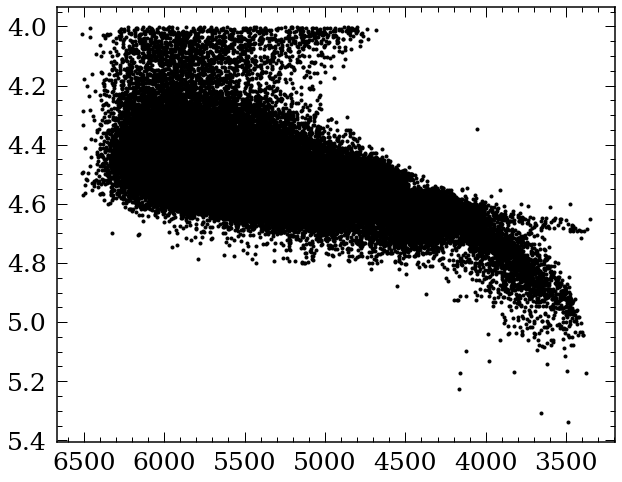

In [194]:
plt.figure(figsize=(10,8))
plt.plot(df_rvar['teff_calc'],df_rvar['logg'],'k.')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

## real ages (real chisq)

In [197]:
df_rvar['Prot_log']=np.log10(df_rvar['Prot_predict'])
#df_rvar['Prot_log']=np.log10(df_rvar['Prot'])

df_rvar=df_rvar.dropna(subset=['Prot_log','teff_calc','abs_G'])

In [211]:
#### chisq

df_rvar['vel_dis'],df_rvar['kin_age']=getkinAges(df_rvar,['teff_calc','Prot_log','abs_G'],
           [350.0, 0.5, 0.173333])
'''

df_rvar['vel_dis'],df_rvar['kin_age']=getkinAges(df_rvar,['teff_calc','Prot_log'],
           [200.0, 0.1])
'''

100%|██████████| 77292/77292 [01:56<00:00, 660.89it/s]
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in log
/Users/lucy/anaconda3/lib/python3.7/site-packages/numpy/lib/polynomial.py:675: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


"\n\ndf_rvar['vel_dis'],df_rvar['kin_age']=getkinAges(df_rvar,['teff_calc','Prot_log'],\n           [200.0, 0.1])\n"

Text(0, 0.5, 'Rotation Period [days]')

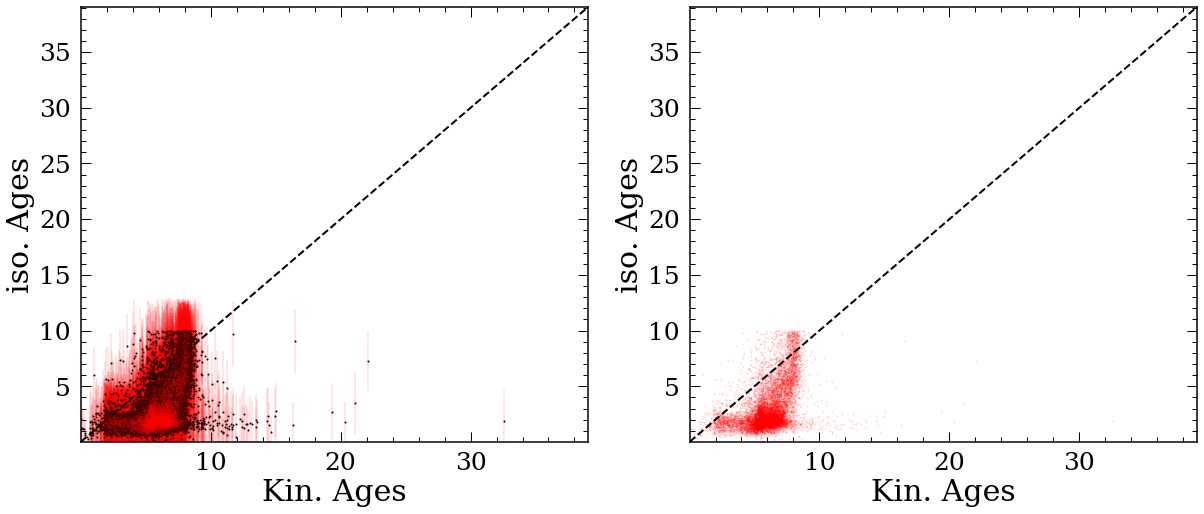

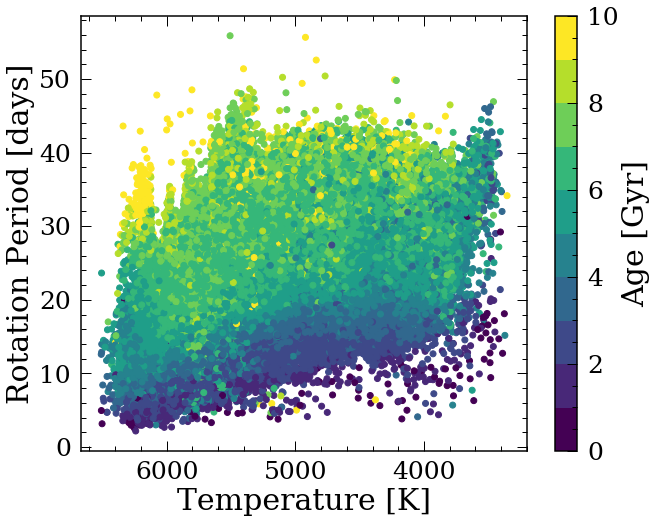

In [213]:
df_rvar_plot=df_rvar.loc[df_rvar['iso_age']<10]
df_rvar_plot=df_rvar_plot.loc[df_rvar_plot['iso_age_err1']<3]


plt.figure(figsize=(20,8))
plt.subplot(1,2,1)

plt.errorbar(df_rvar_plot['kin_age'], df_rvar_plot['iso_age'],
             yerr=df_rvar_plot['iso_age_err1'],fmt='ro',alpha=0.1,markersize=1)
plt.plot(df_rvar_plot['kin_age'], df_rvar_plot['iso_age'],'ko',alpha=1,markersize=1)
minage=min(min(df_rvar_plot['iso_age']),min(df_rvar_plot['kin_age']))
maxage=max(max(df_rvar_plot['iso_age']),max(df_rvar_plot['kin_age']))

plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
plt.xlim([0.8*minage,1.2*maxage])
plt.ylim([0.8*minage,1.2*maxage])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')
plt.subplot(1,2,2)
plt.plot(df_rvar_plot['kin_age'], df_rvar_plot['iso_age'],'ro',alpha=0.1,markersize=1)

plt.plot([0.8*minage,1.2*maxage],[0.8*minage,1.2*maxage],'k--')
plt.xlim([0.8*minage,1.2*maxage])
plt.ylim([0.8*minage,1.2*maxage])
plt.xlabel('Kin. Ages')
plt.ylabel('iso. Ages')

plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',10)
plt.scatter(df_rvar['teff_calc'],df_rvar['Prot_predict'],
            c=df_rvar['kin_age'],cmap=cm,vmin=0,vmax=10)
cb=plt.colorbar()

cb.set_label('Age [Gyr]')
plt.gca().invert_xaxis()
plt.xlabel('Temperature [K]')
plt.ylabel('Rotation Period [days]')


#df_prot_s.to_pickle('minchisq.pkl')

# Train Astraea to get all ages and compare

In [200]:
traincol=['abs_G', 'Rvar','logg', 'b','r_est','l',
         'parallax','teff_calc']

df_prot=df_prot.dropna(subset=traincol)
df_prot=df_prot.dropna(subset=['kin_age','kin_age_err'])
print(len(df_prot))

20039


In [201]:
regr, regr_outs = Astraea.RFregressor(df_prot, traincol,
                                      target_var='kin_age', target_var_err='kin_age_err', n_estimators=100)

Simpliest example:
 regr,regr_outs = RFregressor(df,testF)

Fraction of data used to train: 0.8
# of Features attempt to train: 8
Features attempt to train: ['abs_G', 'Rvar', 'logg', 'b', 'r_est', 'l', 'parallax', 'teff_calc']
20039 stars in dataframe!
20039 total stars used for RF!
16031 training stars!
Finished training! Making predictions!
Finished predicting! Calculating statistics!
Median Relative Error is: 0.060596607900489305
Average chi^2 is: 121102776084.83727
Finished!


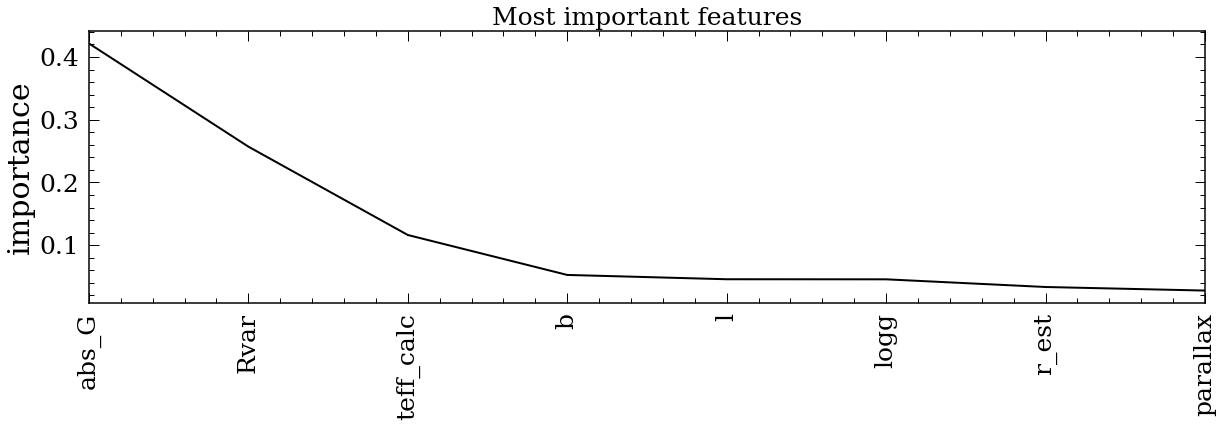

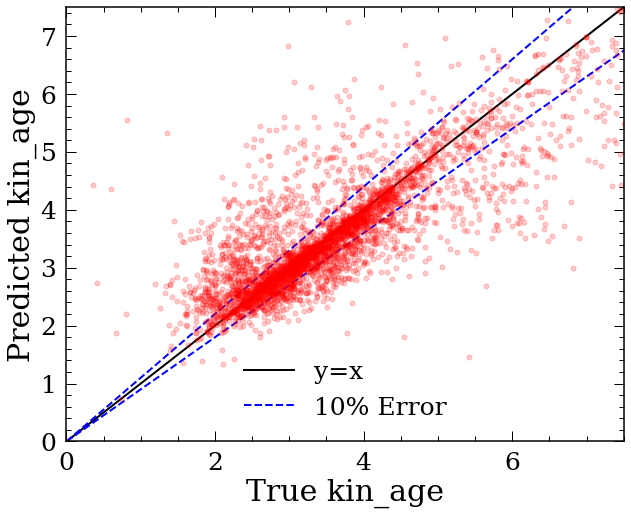

In [202]:
Astraea.plot_result(regr_outs['actrualF'], regr_outs['importance'], regr_outs['prediction'],
                    regr_outs['y_test'], labelName='kin_age', MS=10)

In [203]:
#df_rvar['Prot']=df_rvar['Prot_predict']
df_rvar['predict_kin_age'] = regr.predict(df_rvar[regr_outs['actrualF']])


(0, 10)

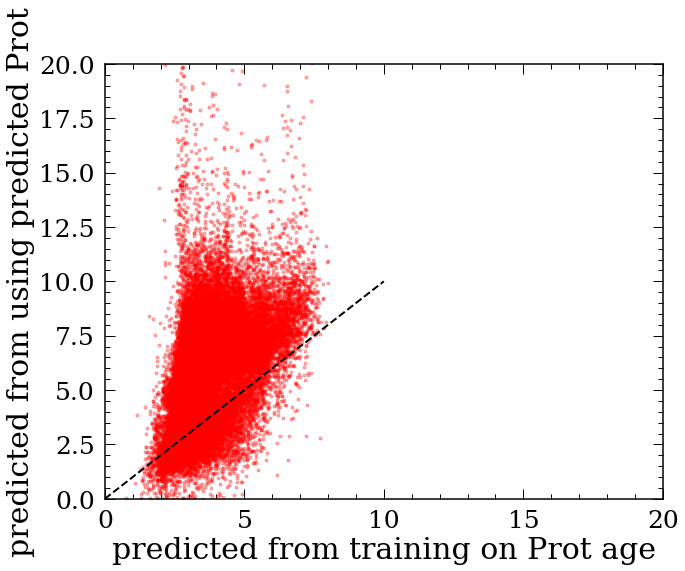

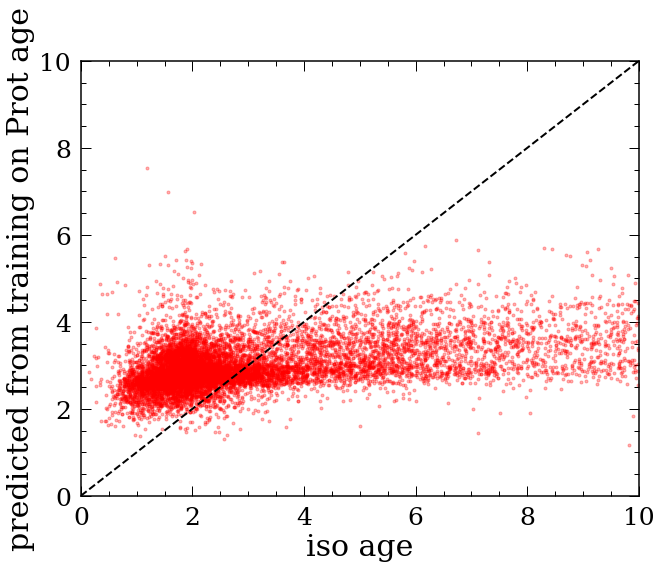

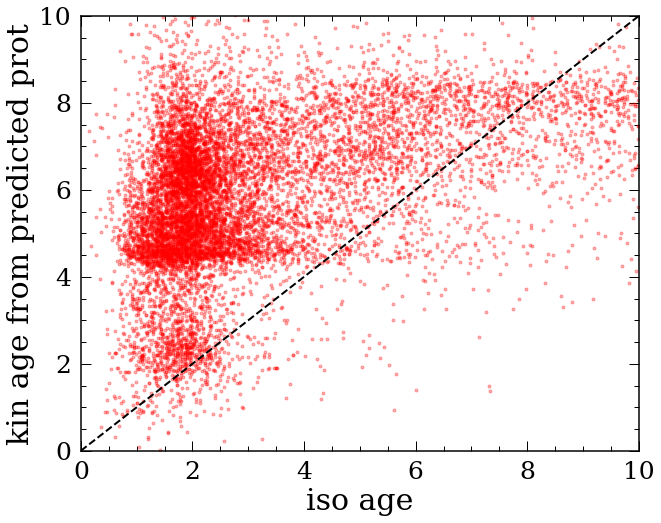

In [204]:
plt.figure(figsize=(10,8))
plt.plot(df_rvar['predict_kin_age'],df_rvar['kin_age'],'r.',alpha=0.3)
plt.xlabel('predicted from training on Prot age')
plt.ylabel('predicted from using predicted Prot')
plt.plot([0,10],[0,10],'k--')
plt.xlim([0,20])
plt.ylim([0,20])

df_rvar_iso_plot=df_rvar.loc[df_rvar['iso_age']<10]
df_rvar_iso_plot=df_rvar_iso_plot.loc[df_rvar_iso_plot['iso_age_err1']<3]
plt.figure(figsize=(10,8))
plt.plot(df_rvar_iso_plot['iso_age'],df_rvar_iso_plot['predict_kin_age'],'r.',alpha=0.3)
plt.xlabel('iso age')
plt.ylabel('predicted from training on Prot age')
plt.plot([0,10],[0,10],'k--')
plt.xlim([0,10])
plt.ylim([0,10])

plt.figure(figsize=(10,8))
plt.plot(df_rvar_iso_plot['iso_age'],df_rvar_iso_plot['kin_age'],'r.',alpha=0.3)
plt.xlabel('iso age')
plt.ylabel('kin age from predicted prot')
plt.plot([0,10],[0,10],'k--')
plt.xlim([0,10])
plt.ylim([0,10])

Text(0, 0.5, 'Rotation Period [days]')

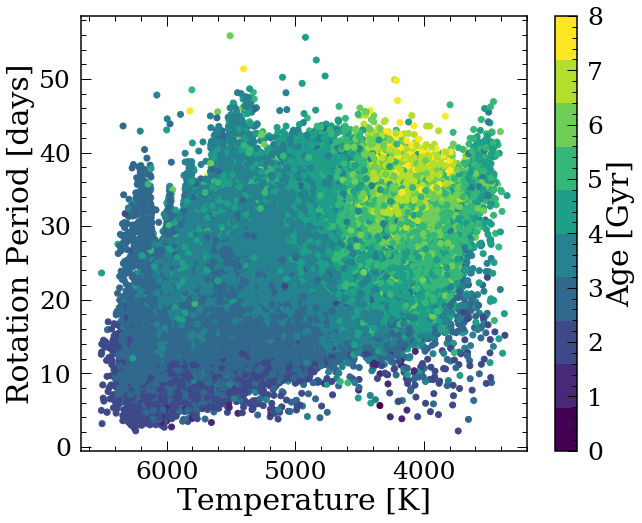

In [205]:
plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('viridis',10)
plt.scatter(df_rvar['teff_calc'],df_rvar['Prot_predict'],
            c=df_rvar['predict_kin_age'],cmap=cm,vmin=0,vmax=8)
cb=plt.colorbar()

cb.set_label('Age [Gyr]')
plt.gca().invert_xaxis()
plt.xlabel('Temperature [K]')
plt.ylabel('Rotation Period [days]')



In [214]:
df_rvar.to_pickle('KinageAllKepler.pkl')

## Compare these ages with AS stars

In [216]:
ASstars=pd.read_table('/Users/lucy/Desktop/KeplerAges/ASage.webarchive',delimiter=',',skiprows=2)
ASstars=ASstars.dropna(subset=['KIC'])

seismicKID=[12069424,12069449,3427720,3656476,5184732,6116048,6196457,6521045,7680114,7871531,8006161,8349582,
           9098294,9139151,9955598,10454113,10586004,10644253,10963065,11244118,11401755]

seismicAge=[7.07,6.82,2.23,8.13,4.17,6.23,5.51,6.24,7.19,9.15,5.04,7.93,7.28,1.71,6.43,2.03,6.35,
            1.07,4.36,6.43,5.85]
seismicAge_err=[0.46,0.28,0.17,0.59,0.40,0.37,0.71,0.37,0.70,0.47,0.17,0.94,0.51,0.19,0.47,0.29,
                1.37,0.25,0.46,0.58,0.93]

for i in ASstars['KIC'].unique():
    AS_single=ASstars.loc[ASstars['KIC']==i]
    seismicKID.append(int(i))
    seismicAge.append(np.mean(AS_single['Age']))
    seismicAge_err.append((max(AS_single['Age'])-min(AS_single['Age']))/2.)

    
All_ASstars=pd.DataFrame(np.array((seismicKID,seismicAge,seismicAge_err)).T,
                         columns=['KID','ASAge','ASAge_err'])

Clusters_cm=pd.merge(All_ASstars,df_rvar,left_on='KID',right_on='KID',how='inner')
Clusters_cm

,KID,ASAge,ASAge_err,KIC,iso_mass,iso_mass_err1,iso_mass_err2,iso_teff,iso_teff_err1,iso_teff_err2,...,rp_dered,bprp_dered,G_dered,teff_calc,abs_G,Prot_predict,Prot_log,vel_dis,kin_age,predict_kin_age
0,3427720.0,2.230000,0.17000,3427720,1.060,0.067,-0.071,6037.9,112.6,-108.6,...,8.603257,0.742274,9.038882,6018.698508,4.177233,19.748950,1.295544,19.157592,6.369355,3.104799
1,3427720.0,2.330517,0.10935,3427720,1.060,0.067,-0.071,6037.9,112.6,-108.6,...,8.603257,0.742274,9.038882,6018.698508,4.177233,19.748950,1.295544,19.157592,6.369355,3.104799
2,3656476.0,8.130000,0.59000,3656476,1.080,0.063,-0.070,5676.2,97.3,-92.0,...,8.969466,0.882620,9.472733,5587.140023,4.166663,38.204650,1.582116,22.607876,8.267532,3.425906
3,3656476.0,8.511200,0.57125,3656476,1.080,0.063,-0.070,5676.2,97.3,-92.0,...,8.969466,0.882620,9.472733,5587.140023,4.166663,38.204650,1.582116,22.607876,8.267532,3.425906
4,6116048.0,6.230000,0.37000,6116048,1.020,0.071,-0.070,6057.4,118.6,-113.8,...,7.938728,0.734601,8.369842,6041.659215,4.000063,23.599817,1.372909,20.750531,7.223264,2.750790
5,6116048.0,6.474333,1.97805,6116048,1.020,0.071,-0.070,6057.4,118.6,-113.8,...,7.938728,0.734601,8.369842,6041.659215,4.000063,23.599817,1.372909,20.750531,7.223264,2.750790
6,7871531.0,9.150000,0.47000,7871531,0.815,0.039,-0.028,5386.2,86.4,-78.4,...,8.662035,0.952060,9.206715,5381.577920,5.091336,30.322650,1.481767,19.585205,6.594721,3.607088
7,7871531.0,9.360683,0.63170,7871531,0.815,0.039,-0.028,5386.2,86.4,-78.4,...,8.662035,0.952060,9.206715,5381.577920,5.091336,30.322650,1.481767,19.585205,6.594721,3.607088
8,8006161.0,5.040000,0.17000,8006161,0.959,0.048,-0.056,5342.0,81.0,-84.9,...,6.768041,0.981189,7.312929,5299.250857,5.152666,23.945033,1.379215,19.050010,6.313108,3.640305
9,8006161.0,4.653233,0.75495,8006161,0.959,0.048,-0.056,5342.0,81.0,-84.9,...,6.768041,0.981189,7.312929,5299.250857,5.152666,23.945033,1.379215,19.050010,6.313108,3.640305


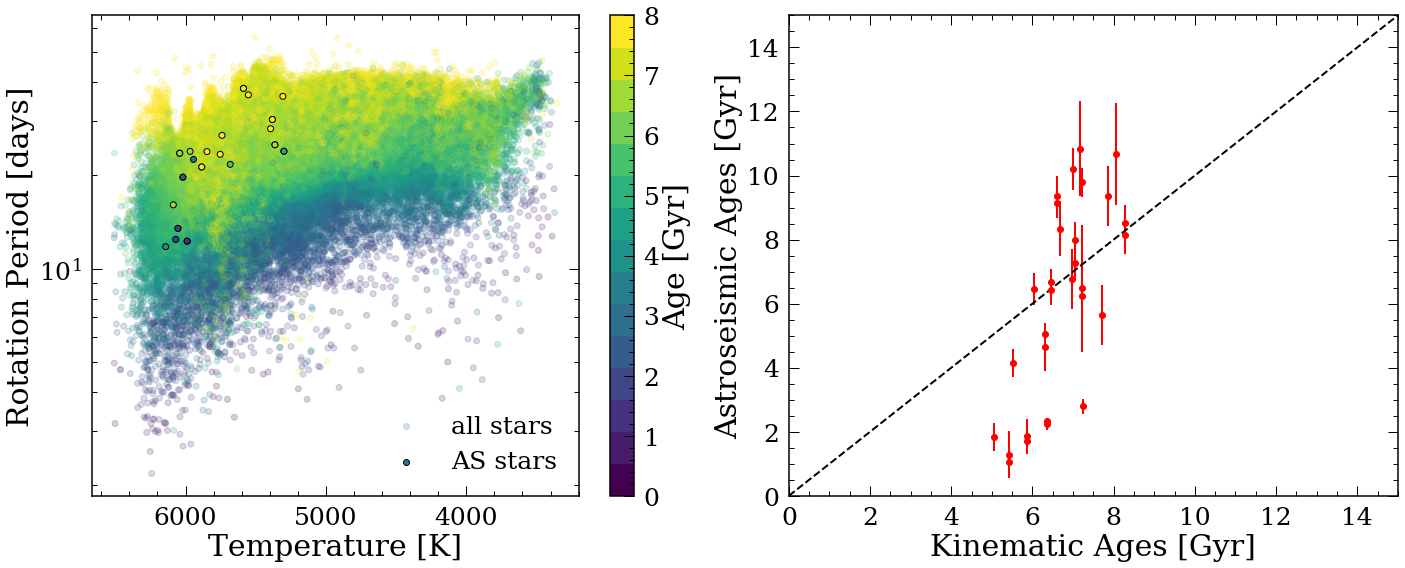

In [217]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
cm = plt.cm.get_cmap('viridis',15)
plt.scatter(df_rvar['teff_calc'],df_rvar['Prot_predict'],
            c=df_rvar['kin_age'],cmap=cm,vmin=0,vmax=8,alpha=0.2,label='all stars')
plt.scatter(Clusters_cm['teff_calc'],Clusters_cm['Prot_predict'],
            c=Clusters_cm['ASAge'],cmap=cm,vmin=0,vmax=8,edgecolor='k',label='AS stars')
cb=plt.colorbar()
plt.legend()

cb.set_label('Age [Gyr]')
plt.gca().invert_xaxis()
plt.yscale('log')
plt.xlabel('Temperature [K]')
plt.ylabel('Rotation Period [days]')



plt.subplot(1,2,2)
plt.plot([0,15],[0,15],'k--')
plt.errorbar(Clusters_cm['kin_age'],Clusters_cm['ASAge'],
             yerr=Clusters_cm['ASAge_err'],fmt='ro')

plt.ylabel('Astroseismic Ages [Gyr]')
plt.xlabel('Kinematic Ages [Gyr]')

plt.xlim([0,15])
plt.ylim([0,15])
plt.tight_layout()



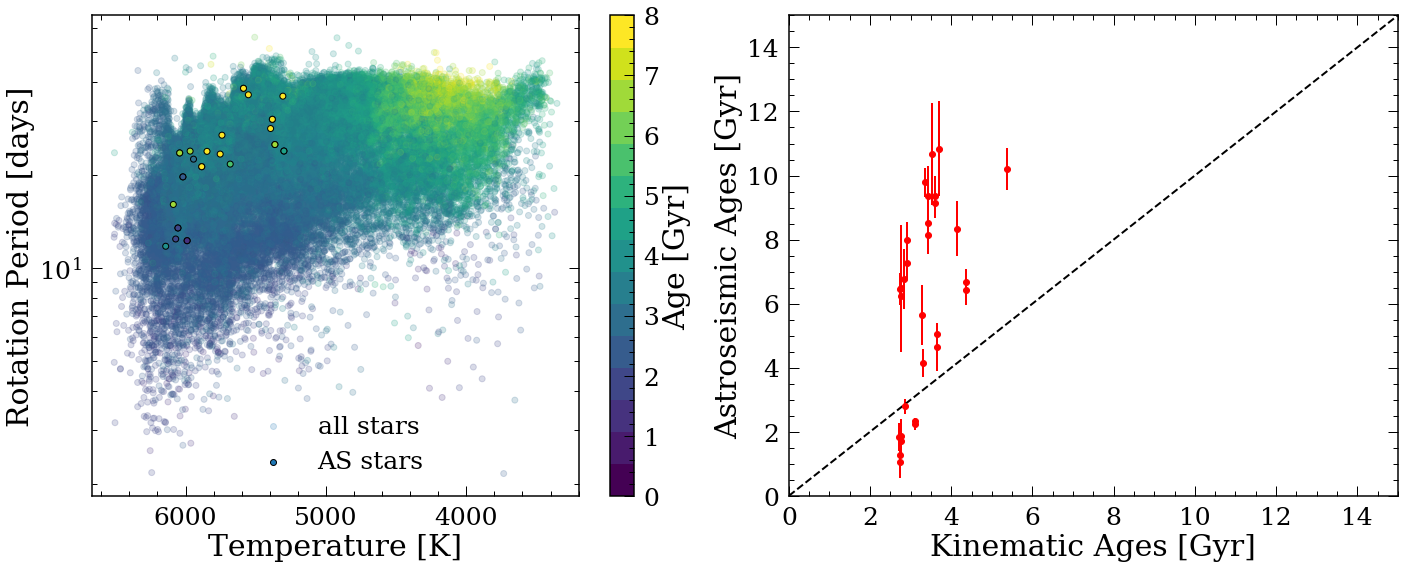

In [209]:
plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
cm = plt.cm.get_cmap('viridis',15)
plt.scatter(df_rvar['teff_calc'],df_rvar['Prot_predict'],
            c=df_rvar['predict_kin_age'],cmap=cm,vmin=0,vmax=8,alpha=0.2,label='all stars')
plt.scatter(Clusters_cm['teff_calc'],Clusters_cm['Prot_predict'],
            c=Clusters_cm['ASAge'],cmap=cm,vmin=0,vmax=8,edgecolor='k',label='AS stars')
cb=plt.colorbar()
plt.legend()

cb.set_label('Age [Gyr]')
plt.gca().invert_xaxis()
plt.yscale('log')
plt.xlabel('Temperature [K]')
plt.ylabel('Rotation Period [days]')



plt.subplot(1,2,2)
plt.plot([0,15],[0,15],'k--')
plt.errorbar(Clusters_cm['predict_kin_age'],Clusters_cm['ASAge'],
             yerr=Clusters_cm['ASAge_err'],fmt='ro')

plt.ylabel('Astroseismic Ages [Gyr]')
plt.xlabel('Kinematic Ages [Gyr]')

plt.xlim([0,15])
plt.ylim([0,15])
plt.tight_layout()


